In this file, we reproduce some of the computations of A Mean Field View of the Landscape of Two-Layers Neural Networks by Song Mei, Andrea Montanari, and Phan-Minh Nguyen (https://arxiv.org/abs/1804.06561).

The idea of the work is to study the mean-field limit evolution of the distribution of weights as a neural network trains using vanilla SGD.  To explain further,  suppose our task is classification with labels $\{-1,+1\}$ and we aim to learn the map $(x_i,y_i)$. Let d be the input dimension, the neural network we study is:

$$ \hat{y}(x) := \frac{1}{N} \sum_{i=1}^n a_i \sigma(w_i \cdot x_i + b_i) $$

for $x_i \in \mathbb{R}^d $, $w_i \in \mathbb{R}^{d\times D}$ and $b_i \in \mathbb{R}^D$ with $\sigma: \mathbb{R}^D \to \mathbb{R}$.

We refer the collection of variables as $\theta_i = (a_i,w_i,b_i)$ and $\theta = (\theta_i)$. To stress the dependence on the model parameters, we write $\hat{y}(x) = \hat{y}(x,\theta)$

As usual, our model parameters are learned by minimizing a loss function $J$. In this case we choose to mimize population risk
$$ R_N(\theta) = E\{[y-\hat{y}(x,\theta)]^2\}$$

For clarity, for those unfamiliar with probability theory, this loss function is essentially MSE loss. In the code we will compute it with MSE as well.

We choose to write it in this, perhaps unfamiliar manner, because this formula allows us to write a mean-field description. 
 ( which is the same as l^2 loss). To optimize, we use stocahstic gradient descent (sgd) and the SGD dynamics (the algorithm we use) are given by

$$ \theta(t+\Delta t) = \theta(t) + \xi(t)\nabla_\theta J(y(x), \hat{y}(x,\theta)) $$

for some step size $\xi(t)$ which may vary as the number of steps increases. Notice here, we are intentionally trying to think of SGD stepping as something continuous like time.



We express the population risk $R_N(\theta) = \mathbb{E}[(y - \hat{y}(x;\theta))^2]$ as:

$$
R_N(\theta) = R_{\#} + \frac{2}{N} \sum_{i=1}^{N} V(\theta_i) + \frac{1}{N^2} \sum_{i,j=1}^{N} U(\theta_i, \theta_j),
$$

where the potentials are defined as:

$$
V(\theta) = -\mathbb{E} \{ y \sigma_{*} (x; \theta) \}, \quad U(\theta_1, \theta_2) = \mathbb{E} \{ \sigma_{*} (x; \theta_1) \sigma_{*} (x; \theta_2) \}.
$$

Here, $U(\cdot, \cdot)$ is a symmetric positive semidefinite kernel. The constant $R_{\#} = \mathbb{E} \{ y^2 \}$ represents the risk of the trivial predictor $\hat{y} = 0$.

Since $R_N(\theta)$ depends on $\theta_1, \dots, \theta_N$ only through their empirical distribution:

$$
\hat{\rho}^{(N)} = \frac{1}{N} \sum_{i=1}^{N} \delta_{\theta_i},
$$

this suggests defining a risk function for $\rho \in \mathcal{P}(\mathbb{R}^D)$, where $\mathcal{P}(\Omega)$ represents the space of probability distributions on $\Omega$:

$$
R(\rho) = R_{\#} + 2 \int V(\theta) \rho(d\theta) + \int U(\theta_1, \theta_2) \rho(d\theta_1) \rho(d\theta_2).
$$

Formal relationships between $R_N(\theta)$ and $R(\rho)$ can be established. Under mild assumptions, we have:

$$
\inf_{\theta} R_N(\theta) = \inf_{\rho} R(\rho) + O(1/N).
$$


In the paper, it is shown that stochastic gradient descent is well approximated by a continuum dynamics. 

Namely, assume that the step size in SGD is given by $s_k = \varepsilon \xi(k\varepsilon)$, for $\xi: \mathbb{R}_{\geq 0} \to \mathbb{R}_{\geq 0}$ a sufficiently regular function. 

Denoting by 

$$
\hat{\rho}_k^{(N)} = N^{-1} \sum_{i=1}^{N} \delta_{\theta_k^i}
$$ 

the empirical distribution of parameters after $k$ SGD steps, the paper shows that

$$
\hat{\rho}_{t/\varepsilon}^{(N)} \Rightarrow \rho_t
$$ 

when $N \to \infty$, $\varepsilon \to 0$ (where $\Rightarrow$ denotes weak convergence). 

The asymptotic dynamics of $\rho_t$ is defined by the following PDE, which should be referred to as **distributional dynamics (DD)**:

$$
\partial_t \rho_t = 2 \xi(t) \nabla_{\theta} \cdot \left( \rho_t \nabla_{\theta} \Psi(\theta; \rho_t) \right),
$$

where 

$$
\Psi(\theta; \rho) \equiv V(\theta) + \int U(\theta, \theta') \rho(d\theta').
$$
In this file, we reproduce the computations of example 2.1. The problem is compute the model parameter distribution as $N \to \infty$ for the classification task of distinguishing between two Gaussians with the same mean distributed by $N(0, (1+\Delta)^2 I_d)$ and $N(0, (1+\Delta)^2 I_d)$ for some $0<\Delta<1$ and show that the distribution is well-approximated by the solution to **DD**.


Before we get started, because the math section was bit hard, here is a nice set of images which interpolates between a dog and a church based on the usage of big-gan in file 1!

Loading BigGAN-deep-256 from Hugging Face...


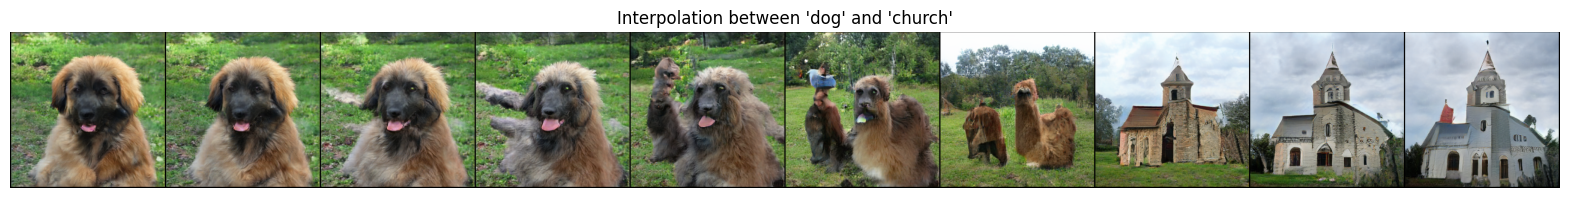

In [4]:
import torch
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from pytorch_pretrained_biggan import BigGAN, one_hot_from_names, truncated_noise_sample

# --- Setup device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Load BigGAN ---
print("Loading BigGAN-deep-256 from Hugging Face...")
biggan = BigGAN.from_pretrained('biggan-deep-256')
biggan.eval()
biggan.to(device)

# --- Define the two object names for interpolation ---
word1 = "dog"  # first object
word2 = "church"  # second object

# Get the one-hot class vectors for each object.
# one_hot_from_names returns a NumPy array so we convert it to a tensor.
class_vector1 = torch.tensor(one_hot_from_names([word1], batch_size=1), device=device)  # shape: [1, 1000]
class_vector2 = torch.tensor(one_hot_from_names([word2], batch_size=1), device=device)  # shape: [1, 1000]

# --- Create 10 interpolated class vectors ---
num_steps = 10
alphas = torch.linspace(0, 1, steps=num_steps, device=device)
interpolated_class_vectors = []
for alpha in alphas:
    # Linear interpolation: (1 - alpha) * vector1 + alpha * vector2.
    inter_vec = (1 - alpha) * class_vector1 + alpha * class_vector2  # shape: [1, 1000]
    interpolated_class_vectors.append(inter_vec)
# Stack into a single tensor of shape [10, 1000]
interpolated_class_vectors = torch.cat(interpolated_class_vectors, dim=0)

# --- Use a fixed noise vector for all images ---
# Sample one noise vector and repeat it for each interpolation step.
noise_vector = truncated_noise_sample(truncation=0.4, batch_size=1)  # shape: [1, 128]
noise_vector = torch.tensor(noise_vector, device=device)
noise_vector = noise_vector.repeat(num_steps, 1)  # shape: [10, 128]

# --- Generate images using the interpolated class vectors ---
with torch.no_grad():
    # The third argument is the truncation value.
    output = biggan(noise_vector, interpolated_class_vectors, 0.4)
    # output shape: [10, 3, H, W]

# --- Post-process and Plot the images ---
# BigGAN outputs are typically in the range [-1, 1]; scale them to [0, 1]
output_images = (output + 1) / 2.0

# Create a grid of images (here, a single row with 10 images)
grid = vutils.make_grid(output_images, nrow=num_steps)
plt.figure(figsize=(20, 4))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.title(f"Interpolation between '{word1}' and '{word2}'")
plt.axis("off")
plt.show()


In this code we produce pytorch code for the Neural network we described above.

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class OneHiddenLayerClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, activation=F.tanh):
        """
        Args:
            input_dim (int): Dimension of the input.
            hidden_dim (int): Number of hidden neurons.
            activation (callable): Activation function for the hidden layer.
        """
        super(OneHiddenLayerClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.activation = activation
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
        self._initialize_weights()
        self._freeze_biases()

    def _initialize_weights(self, scale=1.0):
        with torch.no_grad():
            # d: the number of input dimensions.
            d = self.fc1.weight.shape[1]
            # Set standard deviation as 0.8/sqrt(d) so that each component is ~ N(0, 0.8^2/d)
            std = 0.8 / math.sqrt(d)
            self.fc1.weight.normal_(0, std)
            # Optionally, you might want to initialize fc2 weights using default or custom initialization.
            # For example:
            # self.fc2.weight.normal_(0, std)  # or some other scheme

    def _freeze_biases(self):
        with torch.no_grad():
            # Initialize both biases to 0.
            if self.fc1.bias is not None:
                self.fc1.bias.zero_()
                # Freeze fc1.bias so it is not updated during training.
                self.fc1.bias.requires_grad = False
            if self.fc2.bias is not None:
                self.fc2.bias.zero_()
                # Freeze fc2.bias as well.
                self.fc2.bias.requires_grad = False

    def forward(self, x):
        # Apply the activation on the hidden layer.
        h = self.activation(self.fc1(x))
        out = self.fc2(h)
        # Use tanh activation at the output so that outputs are in [-1, 1].
        return torch.tanh(out)


This code defines a custom PyTorch Dataset, `GaussianDataset`, for a binary classification task where each sample is a 40-dimensional vector drawn from a Gaussian distribution. The class label is randomly assigned (0 or 1) and then mapped to -1 or +1; if the label is 0, the sample is generated from N(0, 1–Δ) (resulting in lower variance and label -1), and if 1, from N(0, 1+Δ) (higher variance and label +1) for some preset $\Delta$. This setup provides training data in which the only discriminative feature is the variance of the input distribution.


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np

# Custom Dataset: each sample is drawn from either N(0, 1-delta) or N(0, 1+delta)
# Labels are now -1 for variance 1-delta and +1 for variance 1+delta.
class GaussianDataset(Dataset):
    def __init__(self, num_examples, sample_length, delta):
        self.num_examples = num_examples
        self.sample_length = sample_length
        self.delta = delta
        # Randomly assign classes: 0 will map to -1, 1 will map to +1.
        self.labels = np.random.randint(0, 2, size=num_examples)

    def __len__(self):
        return self.num_examples

    def __getitem__(self, idx):
        # Determine label and variance.
        label_class = self.labels[idx]
        if label_class == 0:
            variance = 1.0 - self.delta  # variance = 0 for delta=1, i.e. all samples 0.
            label = -1.0
        else:
            variance = 1.0 + self.delta  # variance = 2 for delta=1.
            label = 1.0
        sample = np.random.normal(0.0, np.sqrt(variance), self.sample_length)
        sample = torch.tensor(sample, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.float32)
        return sample, label



We train it once to verify that the classifer works with the choice of $\Delta = 0.2$

In [7]:
# Parameters for the dataset and training
delta = .2             # Fixed Delta: variance is 1+delta or 1-delta.
sample_length = 50        # Each example has 50 i.i.d. samples.
num_examples = 10000      # Total number of examples in the dataset.
batch_size = 64
num_epochs = 20
learning_rate = 1e-3

device = torch.device('cuda')
# Create the dataset and DataLoader.
dataset = GaussianDataset(num_examples, sample_length, delta)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


# Instantiate the model using nn.Tanh() as the activation.
input_dim = sample_length  # Each example is a vector of length 50.
hidden_dim = 50            # You may adjust the hidden layer size.
model = OneHiddenLayerClassifier(input_dim, hidden_dim, activation=nn.Tanh()).to(device)

# Define the loss function and optimizer.
criterion = nn.MSELoss()   # Use MSELoss for targets in [-1,1].
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop.
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_samples, batch_labels in data_loader:
        # Move data to device.
        batch_samples = batch_samples.to(device)
        # Make sure batch_labels has shape [batch_size, 1]
        batch_labels = batch_labels.to(device).unsqueeze(1)
        
        # Zero the gradients.
        optimizer.zero_grad()
        
        # Forward pass.
        outputs = model(batch_samples)
        loss = criterion(outputs, batch_labels)
        
        # Backward pass and optimization.
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * batch_samples.size(0)
    
    epoch_loss = running_loss / len(dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

Epoch 1/20, Loss: 1.0189
Epoch 2/20, Loss: 1.0084
Epoch 3/20, Loss: 1.0058
Epoch 4/20, Loss: 1.0080
Epoch 5/20, Loss: 1.0036
Epoch 6/20, Loss: 1.0064
Epoch 7/20, Loss: 1.0033
Epoch 8/20, Loss: 1.0047
Epoch 9/20, Loss: 1.0032
Epoch 10/20, Loss: 1.0039
Epoch 11/20, Loss: 1.0019
Epoch 12/20, Loss: 1.0028
Epoch 13/20, Loss: 1.0005
Epoch 14/20, Loss: 1.0034
Epoch 15/20, Loss: 1.0025
Epoch 16/20, Loss: 1.0022
Epoch 17/20, Loss: 1.0012
Epoch 18/20, Loss: 1.0026
Epoch 19/20, Loss: 1.0029
Epoch 20/20, Loss: 1.0009


Now we evaluate its performance. Notice, because $\Delta = 0.2$, the classification problem is very hard since the two distributions are pretty similar.

In [8]:
# Simple evaluation on a new batch of samples.
model.eval()
with torch.no_grad():
    test_samples, test_labels = next(iter(data_loader))
    test_samples = test_samples.to(device)
    test_labels = test_labels.to(device)
    predictions = model(test_samples)
    
    # Convert predictions to class labels: +1 if prediction >= 0, else -1.
    predicted_labels = torch.where(predictions >= 0, torch.tensor(1.0, device=device), torch.tensor(-1.0, device=device))
    
    # Flatten both tensors so that they have shape [batch_size]
    true_labels = test_labels.view(-1).cpu()
    predicted_labels = predicted_labels.view(-1).cpu()
    
    # Compute accuracy
    accuracy = (predicted_labels == true_labels).float().mean().item()
    
    print("Test labels:      ", true_labels.numpy())
    print("Predicted labels: ", predicted_labels.numpy())
    print(f"Accuracy: {accuracy * 100:.2f}%")


Test labels:       [ 1. -1.  1. -1. -1. -1.  1.  1. -1. -1.  1.  1.  1.  1. -1. -1. -1.  1.
  1. -1.  1. -1. -1.  1.  1. -1.  1.  1.  1.  1.  1. -1. -1. -1.  1. -1.
 -1.  1. -1.  1.  1.  1.  1. -1.  1. -1.  1. -1. -1.  1. -1. -1.  1.  1.
  1.  1.  1.  1. -1. -1.  1. -1.  1.  1.]
Predicted labels:  [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1. -1.  1. -1. -1. -1.  1.
 -1.  1.  1.  1.  1. -1. -1. -1.  1. -1. -1. -1.  1. -1. -1. -1. -1.  1.
  1. -1.  1.  1.  1.  1.  1.  1. -1. -1. -1.  1. -1.  1.  1. -1.  1.  1.
  1. -1.  1. -1. -1. -1. -1. -1.  1. -1.]
Accuracy: 56.25%


This code sets up and trains a one-hidden-layer neural network for a classification task using a custom Gaussian dataset. Each input sample is a 40-dimensional vector drawn from one of two Gaussian distributions, with variance either $1-\Delta$ or $1+\Delta$, and the labels are $-1$ and $+1$, respectively. The network is instantiated with 800 hidden units and uses a custom piecewise activation function $\sigma(t)$ defined as 
$$
\sigma(t)=
\begin{cases}
-2.5, & t\le 0.5,\\[1mm]
-2.5+\frac{7.5-(-2.5)}{1.5-0.5}(t-0.5), & 0.5<t<1.5,\\[1mm]
7.5, & t\ge 1.5,
\end{cases}
$$ 
and a mean squared error loss is used to train the network with stochastic gradient descent.

During training, the code records the $L^2$ norms of the first layer's weight vectors every few epochs (controlled by `plot_skip`). This is achieved by computing $\|w_i\|_2$ for each hidden neuron $i$, and storing these values to later analyze how the weights evolve during training. The training loop iterates over mini-batches from a `DataLoader` built on the custom dataset, computes the loss, backpropagates gradients, and updates the weights.

After training, the code creates a figure with multiple subplots arranged in 5 rows and 2 columns. In each row, the left subplot displays a histogram (with 50 bins and a uniform $x$-axis range of 0 to 5) of the recorded $L^2$ norms at a specific epoch, while the right subplot shows the evolution of the norms for selected neurons (every 10th neuron) over the recorded epochs. This dual visualization helps illustrate both the distribution and the temporal evolution of the network's weight norms throughout training.


Epoch 1/100, Loss: 1.1392
Epoch 2/100, Loss: 0.8480
Epoch 3/100, Loss: 0.7641
Epoch 4/100, Loss: 0.7311
Epoch 5/100, Loss: 0.7159
Epoch 6/100, Loss: 0.7076
Epoch 7/100, Loss: 0.6929
Epoch 8/100, Loss: 0.6996
Epoch 9/100, Loss: 0.6844
Epoch 10/100, Loss: 0.6707
Epoch 11/100, Loss: 0.6658
Epoch 12/100, Loss: 0.6727
Epoch 13/100, Loss: 0.6600
Epoch 14/100, Loss: 0.6453
Epoch 15/100, Loss: 0.6522
Epoch 16/100, Loss: 0.6416
Epoch 17/100, Loss: 0.6371
Epoch 18/100, Loss: 0.6280
Epoch 19/100, Loss: 0.6256
Epoch 20/100, Loss: 0.6263
Epoch 21/100, Loss: 0.6252
Epoch 22/100, Loss: 0.6225
Epoch 23/100, Loss: 0.6218
Epoch 24/100, Loss: 0.6071
Epoch 25/100, Loss: 0.6099
Epoch 26/100, Loss: 0.6035
Epoch 27/100, Loss: 0.6061
Epoch 28/100, Loss: 0.5919
Epoch 29/100, Loss: 0.5976
Epoch 30/100, Loss: 0.5949
Epoch 31/100, Loss: 0.5869
Epoch 32/100, Loss: 0.5824
Epoch 33/100, Loss: 0.5759
Epoch 34/100, Loss: 0.5760
Epoch 35/100, Loss: 0.5872
Epoch 36/100, Loss: 0.5820
Epoch 37/100, Loss: 0.5926
Epoch 38/1

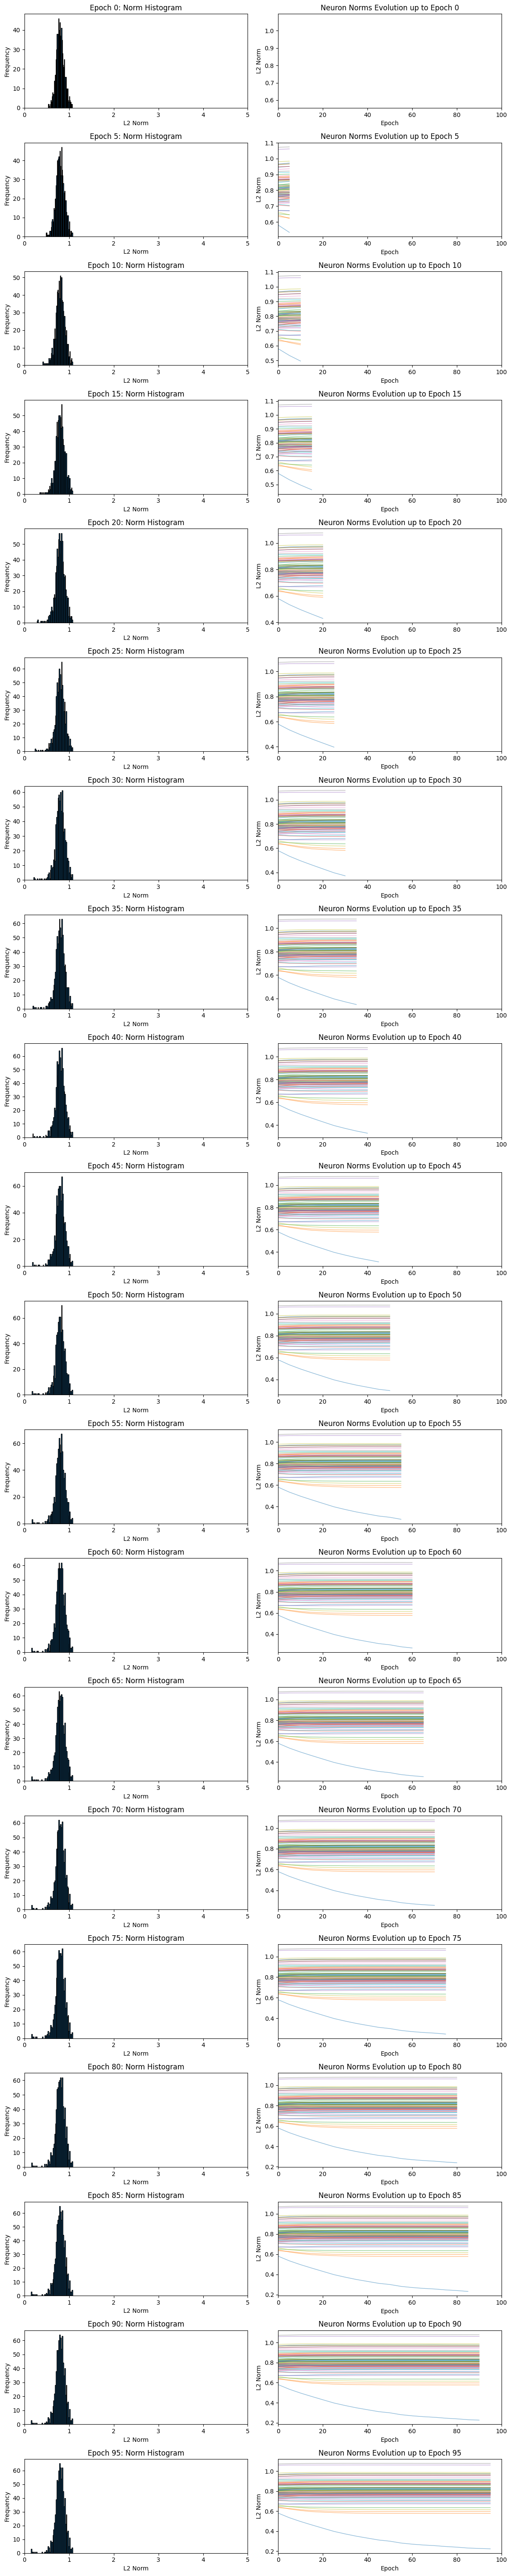

In [18]:
import matplotlib.pyplot as plt

# Parameters for the dataset and training
delta = .2                # Fixed Delta: variance is 1+delta or 1-delta.
sample_length = 40        # Each example has 40 i.i.d. samples.
num_examples = 20000      # Total number of examples in the dataset.
batch_size = 64
num_epochs = 100
learning_rate = 1e-3
plot_skip = 5

# Create the dataset and DataLoader.
dataset = GaussianDataset(num_examples, sample_length, delta)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)




# Define the custom activation function:
def custom_activation(t):
    """
    Custom activation function σ(t) defined piecewise:
       σ(t) = s1 for t <= t1,
       σ(t) = s2 for t >= t2,
       σ(t) is linear for t in (t1, t2).
    where:
       t1 = 0.5, t2 = 1.5, s1 = -2.5, s2 = 7.5.
    """
    t1, t2 = 0.5, 1.5
    s1, s2 = -2.5, 7.5
    # Compute linear interpolation for t in (t1, t2)
    linear_part = s1 + (s2 - s1) * (t - t1) / (t2 - t1)
    return torch.where(t <= t1, torch.full_like(t, s1),
                       torch.where(t >= t2, torch.full_like(t, s2), linear_part))



# Instantiate the model
input_dim = sample_length
hidden_dim = 800
model = OneHiddenLayerClassifier(input_dim, hidden_dim, activation=custom_activation).to(device)

# Loss and optimizer
criterion = nn.MSELoss()   # Use MSELoss for targets in [-1,1].
optimizer = optim.SGD(model.parameters(), lr=learning_rate)


# Containers to record data every other epoch.
recorded_epochs = []      # list of epoch numbers at which we record the weights
recorded_norms = []       # list of numpy arrays: each is the vector of L2 norms (length = hidden_dim)

# Training loop with recording every other epoch.
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_samples, batch_labels in data_loader:
        batch_samples = batch_samples.to(device)
        batch_labels = batch_labels.to(device).unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(batch_samples)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * batch_samples.size(0)
    epoch_loss = running_loss / len(dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")
    
    # Record the L2 norms of fc1 weights every epoch multiple of plot_skip.
    if epoch % plot_skip == 0:
        with torch.no_grad():
            weight_matrix = model.fc1.weight.data  # shape: [hidden_dim, input_dim]
            norms = weight_matrix.norm(p=2, dim=1).cpu().numpy()  # shape: (hidden_dim,)
        recorded_epochs.append(epoch)
        recorded_norms.append(norms)

# After training, create one figure with 10 rows and 2 columns:
# Left column: histogram (50 bins, frequency only, x-axis fixed from 0 to 5).
# Right column: line plot of selected neurons (every 10th) showing evolution of norms.
num_records = len(recorded_epochs)  # should be 10 for 20 epochs (recording every other epoch)
fig, axes = plt.subplots(nrows=num_records, ncols=2, figsize=(12, 3 * num_records))

# Convert the recorded_norms list to a numpy array: shape (num_records, hidden_dim)
recorded_norms = np.array(recorded_norms)

# For each recorded epoch, plot the histogram and the history line plots.
for i in range(num_records):
    # Left column: Histogram of L2 norms at recorded epoch i.
    ax_hist = axes[i, 0] if num_records > 1 else axes[0]
    ax_hist.hist(recorded_norms[i, :], bins=50, edgecolor='black')
    ax_hist.set_title(f"Epoch {recorded_epochs[i]}: Norm Histogram")
    ax_hist.set_xlabel("L2 Norm")
    ax_hist.set_ylabel("Frequency")
    ax_hist.set_xlim(0, 5)  # Set uniform x-axis range from 0 to 5
    
    # Right column: Line plot of each neuron's norm evolution up to epoch i.
    ax_line = axes[i, 1] if num_records > 1 else axes[1]
    for neuron in range(hidden_dim):
        if neuron % 10 == 0:
            ax_line.plot(recorded_epochs[:i+1], recorded_norms[:i+1, neuron],
                         alpha=0.5, linewidth=1)
    ax_line.set_title(f"Neuron Norms Evolution up to Epoch {recorded_epochs[i]}")
    ax_line.set_xlabel("Epoch")
    ax_line.set_ylabel("L2 Norm")
    ax_line.set_xlim(0, num_epochs)
    
plt.tight_layout()
plt.show()


Now we switch to numerically computing the solution of **DD**. The choice of classifying two distrinct centered isotropic Gaussians was chosen because the PDE becomes dramatically simplified due to radial symmetry. 

The simplified PDE governing the evolution of $\overline{\rho}_t$ is:

$$
\partial_t \overline{\rho}_t = 2 \xi(t) \partial_r [\overline{\rho}_t \partial_r \psi_{\infty}(r; \overline{\rho}_t)].
$$ 
with 

$$
\psi_{\infty}(r; \overline{\rho}) = \frac{1}{2} [(q_+, \overline{\rho}) - 1] q_+(r) + \frac{1}{2} [(q_-, \overline{\rho}) + 1] q_-(r). \quad (11.2)
$$


Simulating **DD** computationally intensive. In this setting, the risk is given by:

$$
\overline{R}_\infty(\overline{\rho}) = \frac{1}{2} \left( 1 - \int q_+(r) \overline{\rho}(dr) \right)^2 + \frac{1}{2} \left( 1 + \int q_-(r) \overline{\rho}(dr) \right)^2, \quad (11.1)
$$

where $q_{\pm}(t) = \mathbb{E} \{ \sigma((1 \pm \Delta)t G) \}$, with $G \sim \mathcal{N}(0,1)$. 


We compute the solution to the PDE by assuming a **multiple-deltas ansatz**, that is to say that $\rho_t$ be approximated by:

$$
\overline{\rho}_t = \frac{1}{J} \sum_{i=1}^{J} \delta_{r_i(t)}, \quad (11.3)
$$

where $J \in \mathbb{N}$ is a pre-chosen parameter. If the PDE is initialized at $\overline{\rho}_0$ in this form, then for any $t \geq 0$, $\overline{\rho}_t$ remains in the same form. Given a function $f : \mathbb{R} \mapsto \mathbb{R}$ with compact support, we have:

$$
\frac{1}{J} \sum_{i=1}^{J} f'(r_i(t)) r_i'(t) = \partial_t \langle f, \overline{\rho}_t \rangle = -2 \xi(t) \langle f', \overline{\rho}_t \partial_r \psi_{\infty}(r; \overline{\rho}_t) \rangle.
\quad (11.4)
$$

Expanding the right-hand side:

$$
= -2\xi(t) \frac{1}{J} \sum_{i=1}^{J} f'(r_i(t)) \partial_r \psi_{\infty}(r_i(t); \overline{\rho}_t). \quad (11.5)
$$

Under this ansatz, we define $\overline{R}_\infty(\overline{\rho}_t) = \overline{R}_{\infty, J}(\mathbf{r}(t))$, where $\mathbf{r}(t) = (r_1(t), ..., r_J(t))^\top$. Then,

$$
\overline{R}_{\infty, J}(\mathbf{r}) = \frac{1}{2} \left( 1 - \frac{1}{J} \sum_{i=1}^{J} q_+(r_i) \right)^2 + \frac{1}{2} \left( 1 + \frac{1}{J} \sum_{i=1}^{J} q_-(r_i) \right)^2. \quad (11.6)
$$

Observing that

$$
\partial_r \psi_{\infty}(r_i(t); \overline{\rho}_t) = (J/2)(\nabla \overline{R}_{\infty, J}(\mathbf{r}(t)))_i,
$$

we obtain the gradient flow equation:

$$
\frac{d}{dt} \mathbf{r}(t) = - J \xi(t) \nabla \overline{R}_{\infty, J}(\mathbf{r}(t)). \quad (11.7)
$$

Thus, under the multiple-deltas ansatz, one can numerically simulate the PDE via the above evolution equation of $\mathbf{r}(t)$. In particular, given $\mathbf{r}(t)$, the next step for small displacement $\delta t$ is approximated by:

$$
\mathbf{r}(t + \delta t) \approx \mathbf{r}(t) - J \xi(t) \nabla \overline{R}_{\infty, J}(\mathbf{r}(t)) \delta t. \quad (11.8)
$$

In general, a large $J$ provides a more accurate approximation. However, in some cases, even a small $J$ (such as $J = 1$) can be sufficient.



This code numerically evaluates and plots the functions 
$$
q_{\pm}(t)=\mathbb{E}\{\sigma((1\pm\Delta)tG)\},
$$ 
where $G\sim N(0,1)$ and the activation function $\sigma(x)$ is defined piecewise with $\sigma(x)=-2.5$ for $x\le0.5$, $\sigma(x)=7.5$ for $x\ge1.5$, and linear interpolation between these values for $x\in(0.5,1.5)$. First, the function `sigma(x)` implements this piecewise definition. Then, the function `q(t, Delta, sign)` computes the expected value by numerically integrating the product of $\sigma((1\pm\Delta)t\,g)$ and the standard normal density over all $g\in\mathbb{R}$ using `scipy.integrate.quad`. The code then generates an array of $t$ values between 0.1 and 3.0 and computes $q_+(t)$ (with $1+\Delta$) and $q_-(t)$ (with $1-\Delta$) for each value of $t$. Finally, it plots these functions on the same figure with markers, labeling the curves accordingly, and displays the result.


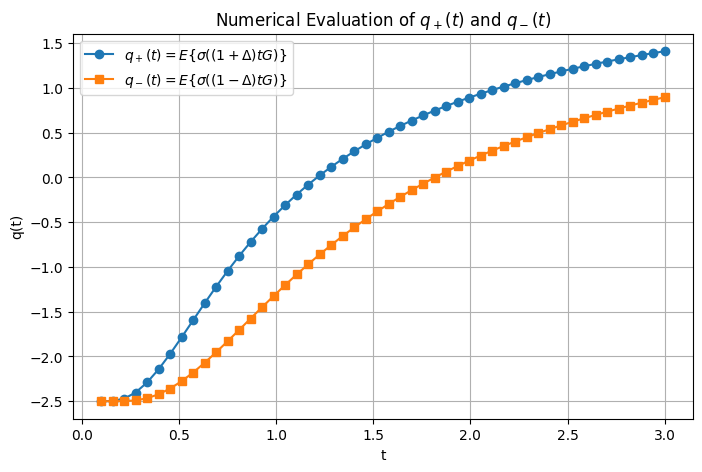

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
import math

# Define the activation function σ(x)
def sigma(x):
    t1 = 0.5
    t2 = 1.5
    s1 = -2.5
    s2 = 7.5
    if x <= t1:
        return s1
    elif x >= t2:
        return s2
    else:
        # Linear interpolation for x in (t1, t2)
        return s1 + (s2 - s1) * (x - t1) / (t2 - t1)

# Define a function to compute q_{±}(t)
def q(t, Delta, sign=1):
    """
    Compute q(t) = E{σ((1 ± Δ) t G)}
    
    Parameters:
      t     : the scalar input t.
      Delta : the Δ parameter.
      sign  : use +1 for q_+(t) (i.e. (1+Δ)t) and -1 for q_-(t) (i.e. (1-Δ)t).
      
    Returns:
      The numerical value of q(t).
    """
    A = (1 + sign * Delta) * t  # this scales the argument of σ
    # Define the integrand as a function of g (with G ~ N(0,1))
    def integrand(g):
        # The standard normal density:
        phi = 1.0 / math.sqrt(2 * math.pi) * math.exp(-g*g / 2)
        return sigma(A * g) * phi
    # Integrate over g from -∞ to ∞
    result, err = quad(integrand, -np.inf, np.inf)
    return result

# Set parameters
Delta = 0.2  # you can change this value
t_values = np.linspace(0.1, 3.0, 50)  # a range of t values
q_plus_vals = []
q_minus_vals = []

# Compute q_+(t) and q_-(t) for each t in t_values
for t in t_values:
    q_plus_vals.append(q(t, Delta, sign=1))
    q_minus_vals.append(q(t, Delta, sign=-1))

# Convert lists to numpy arrays
q_plus_vals = np.array(q_plus_vals)
q_minus_vals = np.array(q_minus_vals)

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(t_values, q_plus_vals, label=r"$q_+(t)=E\{\sigma((1+\Delta)tG)\}$", marker='o')
plt.plot(t_values, q_minus_vals, label=r"$q_-(t)=E\{\sigma((1-\Delta)tG)\}$", marker='s')
plt.xlabel("t")
plt.ylabel("q(t)")
plt.title("Numerical Evaluation of $q_+(t)$ and $q_-(t)$")
plt.legend()
plt.grid(True)
plt.show()


This code numerically simulates the gradient flow of the risk functional 
$$
\overline{R}_{\infty,J}(\mathbf{r}) = \frac{1}{2}\left(1 - \frac{1}{J}\sum_{i=1}^{J}q_+(r_i)\right)^2 + \frac{1}{2}\left(1 + \frac{1}{J}\sum_{i=1}^{J}q_-(r_i)\right)^2,
$$ 
which arises from approximating the solution of a PDE via a multiple-deltas ansatz, 
$$
\overline{\rho}_t = \frac{1}{J}\sum_{i=1}^{J}\delta_{r_i(t)}.
$$ 
The code first defines a piecewise activation function $\sigma(x)$ and then computes $q(t)=\mathbb{E}\{\sigma((1\pm\Delta)tG)\}$ with $G\sim N(0,1)$ using numerical integration. Using these, it constructs $\overline{R}_{\infty,J}$ and approximates its gradient via finite differences.

Next, the code sets up the gradient flow ODE 
$$
\frac{d}{dt}\mathbf{r}(t)=-J\,\xi(t)\nabla\overline{R}_{\infty,J}(\mathbf{r}(t)),
$$ 
with $\xi(t)=1$. The initial condition is chosen by sampling, for each $i=1,\dots,J$, a $d$-dimensional vector $Z_i\sim N(0,(0.8^2/d)I_d)$ (with $d=40$) and setting $r_i(0)=\|Z_i\|_2$. The ODE is then solved over the interval $t\in[0,10]$ using `solve_ivp`, and the evolution of selected components of $\mathbf{r}(t)$ is optionally plotted.


Initial r(0): [0.76279207 0.87860365 0.83211333 0.83508981 0.75004213 0.87571962
 0.8642302  0.8772256  0.77570871 0.93954775 0.67436451 0.60453136
 1.01085881 0.84187095 0.93691269 0.79519168 0.79825883 0.91416828
 0.68438321 0.76780809 0.87881177 0.82375534 0.80137752 0.97995682
 0.79433224 0.6560315  0.7255845  0.97769208 0.72493231 0.81685581
 0.84725897 0.71904507 0.80367673 0.77091504 0.72573832 0.83226469
 0.74519231 0.75124691 0.74023252 1.03159312]
Final r(t): [1.45756229 1.45335737 1.45862196 1.48879278 1.44886116 1.46951789
 1.50346978 1.46009762 1.44653911 1.46007502 1.45266808 1.49558615
 1.4672848  1.48326437 1.46456034 1.45425263 1.45467459 1.54348053
 1.45799017 1.45349218 1.46730078 1.45857721 1.45679451 1.46659319
 1.46700969 1.45283429 1.45900692 1.44484298 1.45807109 1.44378626
 1.4589525  1.42847639 1.45663456 1.44288868 1.46871948 1.44774124
 1.45396574 1.43294224 1.45608972 1.47004358]


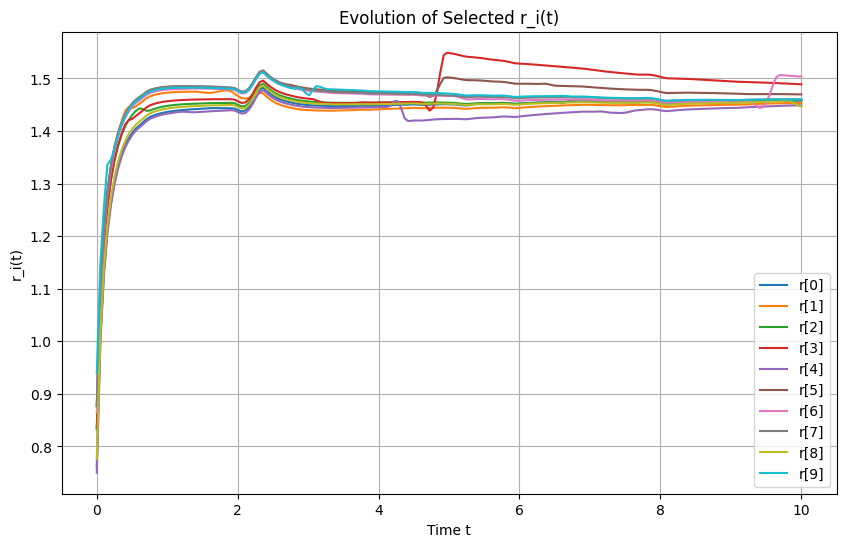

In [11]:
import numpy as np
import math
from scipy.integrate import quad, solve_ivp
import matplotlib.pyplot as plt

# ----------------------------
# Part 1. Define the functions q and R_infty_J
# ----------------------------

def sigma(x):
    """
    Piecewise activation function:
      sigma(x) = -2.5        if x <= 0.5,
      sigma(x) = linear interp if 0.5 < x < 1.5,
      sigma(x) = 7.5         if x >= 1.5.
    """
    t1 = 0.5
    t2 = 1.5
    s1 = -2.5
    s2 = 7.5
    if x <= t1:
        return s1
    elif x >= t2:
        return s2
    else:
        return s1 + (s2 - s1) * (x - t1) / (t2 - t1)

def q(t, Delta, sign=1):
    """
    Compute q(t) = E{ sigma((1 ± Δ) t G) } with G ~ N(0,1)
    """
    A = (1 + sign * Delta) * t  # scaling factor
    def integrand(g):
        phi = 1.0 / math.sqrt(2 * math.pi) * math.exp(-g*g/2)
        return sigma(A * g) * phi
    result, err = quad(integrand, -np.inf, np.inf)
    return result

def R_infty_J(r, Delta):
    """
    Compute:
      R_infty,J(r) = 0.5*(1 - (1/J)*sum_i q_+(r_i))^2 + 0.5*(1 + (1/J)*sum_i q_-(r_i))^2.
      
    r : array-like, shape (J,)
    Delta: scalar Δ parameter.
    """
    r = np.array(r)
    J = len(r)
    q_plus_vals = np.array([q(ri, Delta, sign=1) for ri in r])
    q_minus_vals = np.array([q(ri, Delta, sign=-1) for ri in r])
    term1 = 1 - (1.0/J)*np.sum(q_plus_vals)
    term2 = 1 + (1.0/J)*np.sum(q_minus_vals)
    return 0.5 * term1**2 + 0.5 * term2**2

# ----------------------------
# Part 2. Finite-difference gradient of R_infty_J
# ----------------------------
def grad_R_infty_J(r, Delta, eps=1e-6):
    """
    Approximate the gradient ∇R_infty,J(r) via central finite differences.
    
    r   : numpy array of shape (J,)
    Delta: scalar Δ parameter.
    """
    r = np.array(r)
    grad = np.zeros_like(r)
    for i in range(len(r)):
        dr = np.zeros_like(r)
        dr[i] = eps
        grad[i] = (R_infty_J(r + dr, Delta) - R_infty_J(r - dr, Delta)) / (2 * eps)
    return grad

# ----------------------------
# Part 3. Define the ODE RHS and the time-dependent function ξ(t)
# ----------------------------
def xi(t):
    """
    Time-dependent scalar ξ(t). Here we take ξ(t)=1 constant.
    """
    return 1.0

def ode_rhs(t, r, J, Delta):
    """
    Compute dr/dt = -J * ξ(t) * ∇R_infty,J(r)
    
    Parameters:
      t: time (scalar)
      r: state vector (numpy array of shape (J,))
      J: number of components (int)
      Delta: scalar Δ parameter.
    """
    grad_val = grad_R_infty_J(r, Delta)
    return -J * xi(t) * grad_val

# ----------------------------
# Part 4. Set initial condition and solve the ODE.
# ----------------------------
if __name__ == "__main__":
    # Parameters:
    Delta = 0.2      # Δ parameter
    J = 40          # number of neurons/components
    d = 40           # input dimension for each neuron (for weight initialization)
    
    # For each i in 1,...,J, sample Z_i ~ N(0, (0.8^2/d) I_d)
    # and set r_i(0) = ||Z_i||_2.
    sigma_Z = 0.8 / math.sqrt(d)
    r0 = np.zeros(J)
    for i in range(J):
        # Generate a d-dimensional vector from N(0, sigma_Z^2 I_d)
        Z_i = np.random.normal(0, sigma_Z, size=d)
        r0[i] = np.linalg.norm(Z_i)
    
    print("Initial r(0):", r0)
    
    # Define time span for the ODE solution.
    t_span = (0, 10)  # t from 0 to 10
    t_eval = np.linspace(t_span[0], t_span[1], 200)
    
    # Solve the ODE
    sol = solve_ivp(fun=lambda t, r: ode_rhs(t, r, J, Delta),
                    t_span=t_span,
                    y0=r0,
                    t_eval=t_eval,
                    method='RK45')
    
    # Extract the solution trajectory: r_traj has shape (J, len(t_eval))
    r_traj = sol.y
    print("Final r(t):", r_traj[:, -1])
    
    # (Optional) Plot the evolution of a few components
    plt.figure(figsize=(10, 6))
    for i in range(min(10, J)):
        plt.plot(sol.t, r_traj[i, :], label=f"r[{i}]")
    plt.xlabel("Time t")
    plt.ylabel("r_i(t)")
    plt.title("Evolution of Selected r_i(t)")
    plt.legend()
    plt.grid(True)
    plt.show()


This code approximates and visualizes the density of the weight values $r_i(t)$ at different times using kernel density estimation (KDE). It first sets a very small kernel bandwidth, $\sigma_{kde}=0.01$, to closely approximate the Dirac delta functions in the multiple-deltas ansatz 
$$
\overline{\rho}_t = \frac{1}{J}\sum_{i=1}^{J}\delta_{r_i(t)}.
$$ 
The code combines all weight values from the entire trajectory `r_traj` to determine a suitable range for the $x$-axis, and creates a uniform grid `x_grid` over this range.

Next, the `kernel_density` function is defined to compute the density at each point in `x_grid` by averaging Gaussian kernels centered at each $r_i$; mathematically, this approximates 
$$
\rho(t,x) \approx \frac{1}{J}\sum_{i=1}^{J} \frac{1}{\sqrt{2\pi}\,\sigma_{kde}} \exp\left(-\frac{(x-r_i(t))^2}{2\sigma_{kde}^2}\right).
$$ 
The code then selects time points $t=1,2,\dots,10$, extracts the corresponding $r$ values from the solution (by finding the closest index in `sol.t`), computes the density estimates over the grid, and plots each density estimate in a subplot.

Finally, these density plots are arranged in a 5-row by 2-column grid with uniform $x$-axis limits, ensuring comparability across time. Each subplot is labeled with the corresponding time and includes grid lines for clarity, and a super-title summarizes the overall plot as an approximation of the density 
$$
\rho(t)=\frac{1}{J}\sum_{i=1}^{J}\delta_{r_i(t)}.
$$


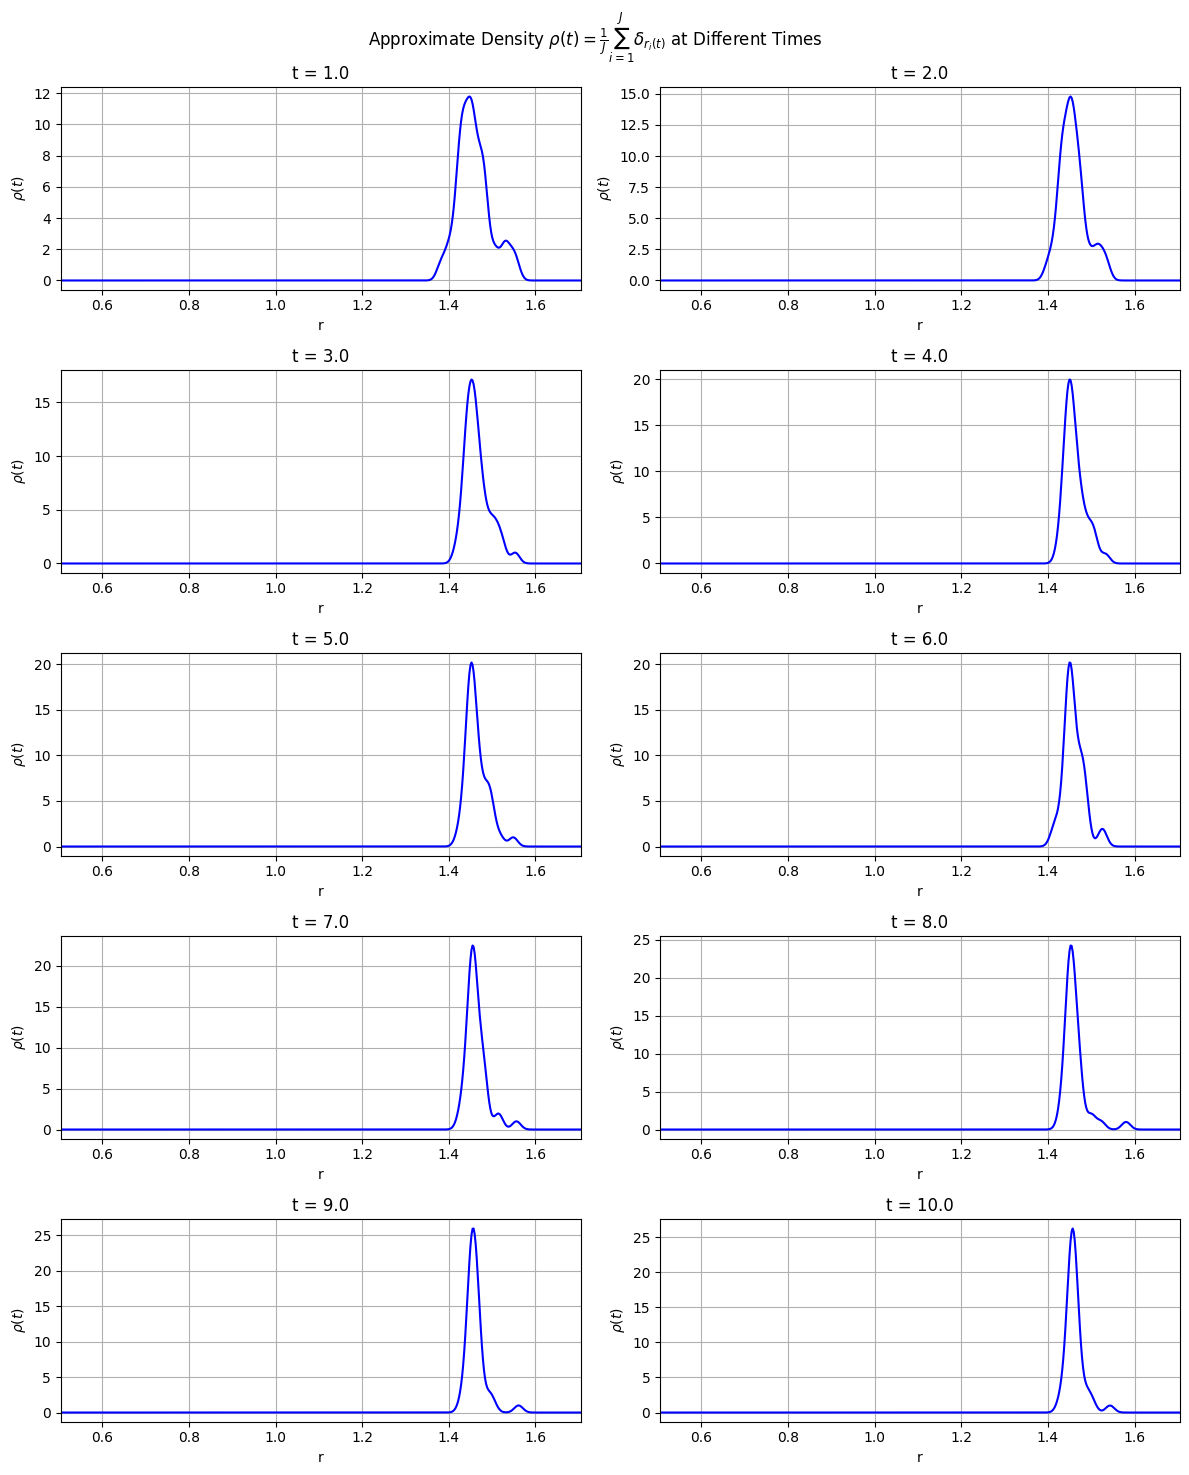

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for the kernel density approximation
sigma_kde = 0.01  # standard deviation for approximating the delta with a narrow Gaussian

# Combine all r values (from all time steps) to choose a good x-grid.
all_r = r_traj.flatten()
x_min = np.min(all_r) - 0.1
x_max = np.max(all_r) + 0.1
x_grid = np.linspace(x_min, x_max, 500)

def kernel_density(r_values, x_grid, sigma):
    """
    Compute a kernel density estimate for a set of points r_values on the grid x_grid,
    using a Gaussian kernel with standard deviation sigma.
    
    Parameters:
      r_values : numpy array of shape (J,)
      x_grid   : numpy array of points where the density is evaluated.
      sigma    : standard deviation of the Gaussian kernel.
      
    Returns:
      density : numpy array of the same shape as x_grid.
    """
    # For each x in x_grid, sum the contributions of each r_i.
    # The density at x is 1/J * sum_i N(x; r_i, sigma^2)
    kernels = np.exp(-0.5 * ((x_grid[:, None] - r_values[None, :]) / sigma)**2) / (np.sqrt(2 * np.pi) * sigma)
    density = np.mean(kernels, axis=1)
    return density

# --- Plotting code ---

# Select time points at which to plot the density: t = 1, 2, ..., 10.
t_list = np.arange(1, 11)

# Create a subplot grid with 5 rows and 2 columns.
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 15))
axes = axes.flatten()

# Set a uniform x-axis limit for all subplots.
# Here we use the minimum and maximum of x_grid.
xlim_min, xlim_max = np.min(x_grid), np.max(x_grid)

for i, t_val in enumerate(t_list):
    # Find the index in sol.t closest to t_val.
    idx = np.argmin(np.abs(sol.t - t_val))
    # Extract the r values at that time (r_at_t has shape (J,))
    r_at_t = r_traj[:, idx]
    # Compute the density estimate over the x_grid.
    dens = kernel_density(r_at_t, x_grid, sigma_kde)
    
    ax = axes[i]
    ax.plot(x_grid, dens, color='blue')
    ax.set_title(f"t = {sol.t[idx]:.1f}")
    ax.set_xlabel("r")
    ax.set_ylabel(r"$\rho(t)$")
    ax.set_xlim(xlim_min, xlim_max)  # set uniform x-axis limits
    ax.grid(True)

fig.suptitle(r"Approximate Density $\rho(t) = \frac{1}{J}\sum_{i=1}^J \delta_{r_i(t)}$ at Different Times")
plt.tight_layout()
plt.show()

The distributions appear close, but they are not perfectly overlapping! I'm not really sure why :(

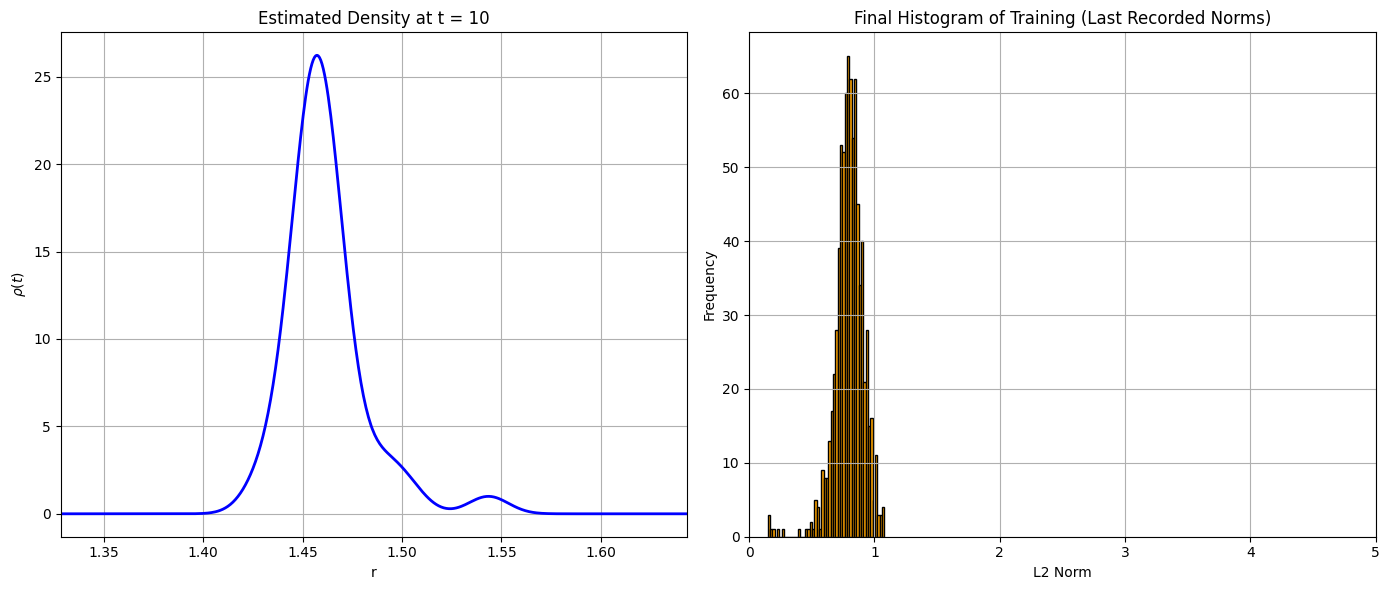

In [22]:

import numpy as np
import matplotlib.pyplot as plt
import math

# Parameters for kernel density approximation
sigma_kde = 0.01  # bandwidth for the Gaussian kernel

# Select time t = 10 using the time array t_eval
t_target = 10
idx = np.argmin(np.abs(t_eval - t_target))
r_at_t = r_traj[:, idx]  # r values at time t = 10

# Create an x-grid based on the range of r_at_t
x_min = np.min(r_at_t) - 0.1
x_max = np.max(r_at_t) + 0.1
x_grid = np.linspace(x_min, x_max, 500)

def kernel_density(r_values, x_grid, sigma):
    """
    Compute a kernel density estimate for r_values on x_grid using a Gaussian kernel.
    """
    kernels = np.exp(-0.5 * ((x_grid[:, None] - r_values[None, :]) / sigma)**2)
    kernels /= (np.sqrt(2 * np.pi) * sigma)
    density = np.mean(kernels, axis=1)
    return density

# Compute the density estimate at t = 10
density = kernel_density(r_at_t, x_grid, sigma_kde)

# For the final histogram, use the last recorded norms from training.
final_norms = recorded_norms[-1, :]

# Create a figure with two subplots: one for the density, one for the histogram.
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 6))

# Plot the density estimate at t = 10.
ax1.plot(x_grid, density, color='blue', lw=2)
ax1.set_title("Estimated Density at t = 10")
ax1.set_xlabel("r")
ax1.set_ylabel(r"$\rho(t)$")
ax1.set_xlim(x_min, x_max)
ax1.grid(True)

# Plot the final histogram from training.
ax2.hist(final_norms, bins=50, edgecolor='black', color='orange')
ax2.set_title("Final Histogram of Training (Last Recorded Norms)")
ax2.set_xlabel("L2 Norm")
ax2.set_ylabel("Frequency")
ax2.set_xlim(0, 5)
ax2.grid(True)

plt.tight_layout()
plt.show()


As you can tell, the are not overlapping super well. I'm not sure what happened! Its a bit strange that they seem to be mirroring each other?!?